In [119]:
import glob, os, sys
import pathlib
import timeit
from sklearn.model_selection import ParameterGrid
import pandas as pd
from IPython.display import display

import numpy as np
from random import random
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import pandas as pd

# data_directory needs to contain files of the pubmed 200k RCT benchmark, 
# into subfolder PubMed_200k_RCT and PubMed_20k_RCT, respectively

#data_directory = '/media/matthias/Big-disk/text/pubmed_200k_and_20k_rct_dataset/'
data_directory = "."


def get_sentence_from_line(line, token_prefix = ''):
    sentence = line.split('\t')[1].lower()
    if token_prefix != '':
        tokens = sentence.split(' ')
        sentence = ' '.join([token_prefix + token for token in tokens])
    return sentence


def get_label_from_line(line):
    return line.split('\t')[0]


def preprocess_corpora(input_filenames, add_position_information = False, included_context_sentence_offset = [], \
                       excluded_chunk_ids = [], omit_labels = False, output_file_postfix = '.preprocessed'):
    for input_filename in input_filenames:

        fin = open(input_filename,'r')

        output_filename = input_filename + output_file_postfix
        fout = open(output_filename, 'w')

        text_chunk_in = ""

        # iterate through lines in input file
        for line in fin:
                
                # lines starting with ### mark beginning of new abstract ('chunk')
                if line.startswith('###'):
                    chunk_id = line
                    text_chunk_in = ''
                
                # blank lines mark end of chunk. process chunk and write to file.
                elif line.isspace() and (chunk_id not in excluded_chunk_ids):
                        chunk_lines = text_chunk_in.splitlines()

                        last_line_index = len(chunk_lines) - 1
                        
                        # iterate through lines in text chunk
                        for chunk_line_number, chunk_line in enumerate(chunk_lines, start=0):

                                sentence = get_sentence_from_line(chunk_line)

                                context_sentences = []
                                
                                # generate context sentences, prepend tokens with 
                                # specific strings based on context sentence offset
                                for sentence_offset in included_context_sentence_offset:
                                    if not (0 <= chunk_line_number + sentence_offset <= last_line_index):
                                        context_sentences.append('no__' + str(sentence_offset))
                                    else: 
                                        context_sentences.append(get_sentence_from_line( \
                                                                    chunk_lines[chunk_line_number+sentence_offset], \
                                                                    token_prefix = str(sentence_offset) + '__'))

                                
                                
                                if add_position_information:
                                    sentence = "sentence__{} of__{} {} {}\n".format( \
                                        str(chunk_line_number), str(last_line_index), sentence, ' '.join(context_sentences))
                                else:
                                    sentence = "{} {}\n".format( \
                                        sentence, ' '.join(context_sentences))
                                
                                if omit_labels:
                                    fout.write(sentence)
                                else:
                                    label = get_label_from_line(chunk_line).lower()

                                    if 'background' in label:
                                            fout.write('__label__background\t'+sentence)
                                    elif 'methods' in label:
                                            fout.write('__label__methods\t'+sentence)
                                    elif 'results' in label:
                                            fout.write('__label__results\t'+sentence)
                                    elif 'conclusions' in label:
                                            fout.write('__label__conclusions\t'+sentence)
                                    elif 'objective' in label:
                                            fout.write('__label__objective\t'+sentence)
                
                # otherwise, this is a line containing a labelled sentence
                else:
                        text_chunk_in += line

        fin.close()
        fout.close()


def fasttext_train(train_filename, model_filename, params, pretrained_vector_file):
    if pretrained_vector_file:
        ! fasttext supervised -input $train_filename -output $model_filename -pretrainedVectors $pretrained_vector_file -dim {params['dim']} -wordNgrams {params['wordNgrams']} -epoch {params['epoch']} -verbose 0
    else:
        ! fasttext supervised -input $train_filename -output $model_filename -dim {params['dim']} -wordNgrams {params['wordNgrams']} -epoch {params['epoch']} -verbose 0


def fasttext_test(model_filename, test_filename):
    y_true = []
    with open(test_filename, 'r') as fin:
        for line in fin:
            y_true.append(line.split('\t')[0])
    
    output = ! fasttext predict $model_filename $test_filename
    y_pred = []
    for line in output:
        y_pred.append(line)
    
    precision = metrics.precision_score(y_true, y_pred, average='weighted')
    recall = metrics.recall_score(y_true, y_pred, average='weighted')
    f1 = metrics.f1_score(y_true, y_pred, average='weighted')
    
    return precision, recall, f1


def train_and_test(train_filename, model_filename, test_filename, params, pretrained_vector_file=None, verbose=False):
    if verbose:
        print("\n" + str(params))
    
    start_time = timeit.default_timer()
    fasttext_train(train_filename, model_filename, params, pretrained_vector_file)
    training_time = timeit.default_timer() - start_time
    
    precision, recall, f1 = fasttext_test(model_filename + '.bin', test_filename)
    results = {'precision': precision, 'recall': recall, 'f1': f1, 'training_time': training_time}
    if verbose:
        print(str(results))
    
    return dict(results, **params)

## Unsupervised pre-training with sent2vec (dim 700)

In [18]:
preprocess_corpora([data_directory + "/PubMed_200k_RCT/train.txt"], \
                   add_position_information = False, included_context_sentence_offset = [], \
                   omit_labels = True, \
                   output_file_postfix = '.preprocessed_labels_removed')

In [63]:
! tail {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed_labels_removed"}

internal medicine residents must be competent in advanced cardiac life support ( acls ) for board certification . 
the purpose was to use a medical simulator to assess baseline proficiency in acls and determine the impact of an intervention on skill development . 
this was a randomized trial with wait-list controls . 
after baseline evaluation in all residents , the intervention group received 4 education sessions using a medical simulator . 
all residents were then retested . 
after crossover , the wait-list group received the intervention , and residents were tested again . 
performance was assessed by comparison to american heart association guidelines for treatment of acls conditions with interrater and internal consistency reliability estimates . 
performance improved significantly after simulator training . 
no improvement was detected as a function of clinical experience alone . 
the educational program was rated highly . 


In [6]:
# number of sentences available for training unsupervised model
! wc -l {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed_labels_removed"}

2211861 ./PubMed_200k_RCT/train.txt.preprocessed_labels_removed


In [19]:
! sent2vec sent2vec -input {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed_labels_removed"} \
 -output sent2vec_200k_RCT -minCount 2 -dim 700 \
    -epoch 5 -wordNgrams 2 -loss ns -neg 10 -thread 10

Read 60M words
Number of words:  214465
Number of labels: 0


Progress: 4.3%  words/sec/thread: 49418  lr: 0.191366  loss: 2.194052  eta: 0h9m  .0%  words/sec/thread: 2406  lr: 0.199985  loss: 7.529378  eta: 3h31m 0.0%  words/sec/thread: 12324  lr: 0.199901  loss: 5.503058  eta: 0h40m 0.1%  words/sec/thread: 15838  lr: 0.199860  loss: 4.914842  eta: 0h31m 0.1%  words/sec/thread: 16905  lr: 0.199846  loss: 4.844295  eta: 0h29m 0.1%  words/sec/thread: 17859  lr: 0.199832  loss: 4.779290  eta: 0h28m 0.1%  words/sec/thread: 22016  lr: 0.199764  loss: 4.445445  eta: 0h22m 0.1%  words/sec/thread: 24058  lr: 0.199723  loss: 4.237591  eta: 0h20m 0.2%  words/sec/thread: 27791  lr: 0.199628  loss: 3.930265  eta: 0h18m 0.2%  words/sec/thread: 28238  lr: 0.199614  loss: 3.910730  eta: 0h17m 0.2%  words/sec/thread: 29522  lr: 0.199573  loss: 3.851612  eta: 0h16m 0.3%  words/sec/thread: 32093  lr: 0.199476  loss: 3.673954  eta: 0h15m 0.3%  words/sec/thread: 32984  lr: 0.199435  loss: 3.614569  eta: 0h15m 0.5%  words/sec/thread: 38821  lr: 0.199024  loss: 3.250

Progress: 28.4%  words/sec/thread: 50106  lr: 0.143232  loss: 1.496315  eta: 0h7m 26.2%  words/sec/thread: 50097  lr: 0.147585  loss: 1.522521  eta: 0h7m 26.2%  words/sec/thread: 50098  lr: 0.147531  loss: 1.522246  eta: 0h7m 26.2%  words/sec/thread: 50098  lr: 0.147516  loss: 1.522147  eta: 0h7m 26.2%  words/sec/thread: 50098  lr: 0.147502  loss: 1.522054  eta: 0h7m 26.3%  words/sec/thread: 50097  lr: 0.147451  loss: 1.521614  eta: 0h7m 26.3%  words/sec/thread: 50098  lr: 0.147437  loss: 1.521548  eta: 0h7m 26.3%  words/sec/thread: 50097  lr: 0.147424  loss: 1.521484  eta: 0h7m 26.3%  words/sec/thread: 50097  lr: 0.147409  loss: 1.521390  eta: 0h7m   words/sec/thread: 50098  lr: 0.147367  loss: 1.521195  eta: 0h7m %  words/sec/thread: 50098  lr: 0.147300  loss: 1.520960  eta: 0h7m 26.4%  words/sec/thread: 50098  lr: 0.147289  loss: 1.520909  eta: 0h7m 26.4%  words/sec/thread: 50098  lr: 0.147275  loss: 1.520903  eta: 0h7m 26.4%  words/sec/thread: 50097  lr: 0.147210  loss: 1.520516  e

Progress: 30.8%  words/sec/thread: 50101  lr: 0.138461  loss: 1.467335  eta: 0h6m 28.4%  words/sec/thread: 50107  lr: 0.143191  loss: 1.496159  eta: 0h7m   loss: 1.496009  eta: 0h7m m 28.4%  words/sec/thread: 50108  lr: 0.143107  loss: 1.495824  eta: 0h7m 28.5%  words/sec/thread: 50108  lr: 0.143093  loss: 1.495744  eta: 0h7m 28.5%  words/sec/thread: 50108  lr: 0.143026  loss: 1.495556  eta: 0h7m 28.5%  words/sec/thread: 50108  lr: 0.142999  loss: 1.495357  eta: 0h7m 0.142959  loss: 1.495180  eta: 0h7m 50108  lr: 0.142932  loss: 1.495022  eta: 0h7m 28.6%  words/sec/thread: 50106  lr: 0.142858  loss: 1.494312  eta: 0h7m 28.6%  words/sec/thread: 50107  lr: 0.142844  loss: 1.494228  eta: 0h7m 28.6%  words/sec/thread: 50107  lr: 0.142831  loss: 1.494171  eta: 0h7m 28.6%  words/sec/thread: 50108  lr: 0.142818  loss: 1.494113  eta: 0h7m 28.6%  words/sec/thread: 50108  lr: 0.142804  loss: 1.494071  eta: 0h7m 28.6%  words/sec/thread: 50108  lr: 0.142776  loss: 1.493961  eta: 0h7m 28.7%  words/

Progress: 32.9%  words/sec/thread: 50096  lr: 0.134192  loss: 1.444225  eta: 0h6m %  words/sec/thread: 50100  lr: 0.138404  loss: 1.467046  eta: 0h6m 30.8%  words/sec/thread: 50100  lr: 0.138390  loss: 1.466996  eta: 0h6m 30.8%  words/sec/thread: 50100  lr: 0.138365  loss: 1.466882  eta: 0h6m 30.8%  words/sec/thread: 50101  lr: 0.138349  loss: 1.466813  eta: 0h6m 30.8%  words/sec/thread: 50101  lr: 0.138334  loss: 1.466732  eta: 0h6m 30.8%  words/sec/thread: 50101  lr: 0.138320  loss: 1.466674  eta: 0h6m 30.8%  words/sec/thread: 50101  lr: 0.138306  loss: 1.466647  eta: 0h6m   words/sec/thread: 50101  lr: 0.138216  loss: 1.465859  eta: 0h6m 50098  lr: 0.138128  loss: 1.465123  eta: 0h6m %  words/sec/thread: 50098  lr: 0.138087  loss: 1.464729  eta: 0h6m 31.0%  words/sec/thread: 50096  lr: 0.138037  loss: 1.464303  eta: 0h6m 31.0%  words/sec/thread: 50096  lr: 0.138025  loss: 1.464257  eta: 0h6m 50096  lr: 0.138011  loss: 1.464197  eta: 0h6m   words/sec/thread: 50096  lr: 0.137983  loss

Progress: 34.9%  words/sec/thread: 50096  lr: 0.130298  loss: 1.423948  eta: 0h6m 32.9%  words/sec/thread: 50096  lr: 0.134134  loss: 1.443952  eta: 0h6m 32.9%  words/sec/thread: 50096  lr: 0.134109  loss: 1.443785  eta: 0h6m 33.0%  words/sec/thread: 50096  lr: 0.134095  loss: 1.443743  eta: 0h6m 33.0%  words/sec/thread: 50096  lr: 0.134013  loss: 1.443401  eta: 0h6m 33.0%  words/sec/thread: 50097  lr: 0.133997  loss: 1.443307  eta: 0h6m 33.0%  words/sec/thread: 50097  lr: 0.133983  loss: 1.443248  eta: 0h6m 33.1%  words/sec/thread: 50092  lr: 0.133736  loss: 1.441190  eta: 0h6m 33.1%  words/sec/thread: 50092  lr: 0.133724  loss: 1.441147  eta: 0h6m 33.2%  words/sec/thread: 50092  lr: 0.133687  loss: 1.440981  eta: 0h6m %  words/sec/thread: 50092  lr: 0.133659  loss: 1.440764  eta: 0h6m 33.2%  words/sec/thread: 50092  lr: 0.133602  loss: 1.440428  eta: 0h6m 33.2%  words/sec/thread: 50093  lr: 0.133589  loss: 1.440405  eta: 0h6m   words/sec/thread: 50092  lr: 0.133575  loss: 1.440261  e

Progress: 37.2%  words/sec/thread: 50082  lr: 0.125580  loss: 1.400321  eta: 0h6m 34.9%  words/sec/thread: 50096  lr: 0.130271  loss: 1.423773  eta: 0h6m 34.9%  words/sec/thread: 50096  lr: 0.130256  loss: 1.423719  eta: 0h6m 34.9%  words/sec/thread: 50096  lr: 0.130229  loss: 1.423634  eta: 0h6m 34.9%  words/sec/thread: 50097  lr: 0.130169  loss: 1.423388  eta: 0h6m 34.9%  words/sec/thread: 50097  lr: 0.130155  loss: 1.423329  eta: 0h6m 34.9%  words/sec/thread: 50097  lr: 0.130141  loss: 1.423257  eta: 0h6m 35.0%  words/sec/thread: 50097  lr: 0.130070  loss: 1.422868  eta: 0h6m 35.0%  words/sec/thread: 50097  lr: 0.130045  loss: 1.422784  eta: 0h6m 35.0%  words/sec/thread: 50097  lr: 0.130005  loss: 1.422651  eta: 0h6m 35.0%  words/sec/thread: 50097  lr: 0.129981  loss: 1.422609  eta: 0h6m 35.0%  words/sec/thread: 50098  lr: 0.129968  loss: 1.422580  eta: 0h6m 35.0%  words/sec/thread: 50098  lr: 0.129953  loss: 1.422509  eta: 0h6m 35.0%  words/sec/thread: 50097  lr: 0.129917  loss: 1.

Progress: 39.3%  words/sec/thread: 50072  lr: 0.121355  loss: 1.382242  eta: 0h6m 37.2%  words/sec/thread: 50083  lr: 0.125526  loss: 1.400147  eta: 0h6m 37.2%  words/sec/thread: 50082  lr: 0.125513  loss: 1.400117  eta: 0h6m 0.125405  loss: 1.399484  eta: 0h6m 37.3%  words/sec/thread: 50082  lr: 0.125339  loss: 1.399015  eta: 0h6m 37.3%  words/sec/thread: 50081  lr: 0.125325  loss: 1.398986  eta: 0h6m 37.4%  words/sec/thread: 50082  lr: 0.125240  loss: 1.398590  eta: 0h6m 37.4%  words/sec/thread: 50081  lr: 0.125158  loss: 1.398308  eta: 0h6m 50079  lr: 0.125064  loss: 1.397761  eta: 0h6m   words/sec/thread: 50079  lr: 0.124968  loss: 1.397033  eta: 0h6m   lr: 0.124955  loss: 1.396989  eta: 0h6m 37.6%  words/sec/thread: 50079  lr: 0.124887  loss: 1.396777  eta: 0h6m 37.6%  words/sec/thread: 50079  lr: 0.124873  loss: 1.396722  eta: 0h6m 37.6%  words/sec/thread: 50080  lr: 0.124858  loss: 1.396675  eta: 0h6m 37.6%  words/sec/thread: 50079  lr: 0.124845  loss: 1.396626  eta: 0h6m 37.6% 

Progress: 41.7%  words/sec/thread: 50060  lr: 0.116655  loss: 1.362284  eta: 0h5m 39.3%  words/sec/thread: 50073  lr: 0.121328  loss: 1.382155  eta: 0h6m 39.4%  words/sec/thread: 50073  lr: 0.121278  loss: 1.381914  eta: 0h6m   loss: 1.381880  eta: 0h6m 39.4%  words/sec/thread: 50074  lr: 0.121228  loss: 1.381664  eta: 0h6m 39.4%  words/sec/thread: 50074  lr: 0.121216  loss: 1.381659  eta: 0h6m   lr: 0.121203  loss: 1.381628  eta: 0h6m 39.4%  words/sec/thread: 50074  lr: 0.121127  loss: 1.381330  eta: 0h6m   lr: 0.121039  loss: 1.380849  eta: 0h6m 39.5%  words/sec/thread: 50073  lr: 0.120940  loss: 1.380357  eta: 0h6m 39.6%  words/sec/thread: 50074  lr: 0.120828  loss: 1.379905  eta: 0h6m %  words/sec/thread: 50073  lr: 0.120746  loss: 1.379587  eta: 0h6m 39.7%  words/sec/thread: 50073  lr: 0.120631  loss: 1.378867  eta: 0h6m %  words/sec/thread: 50073  lr: 0.120616  loss: 1.378811  eta: 0h6m 39.7%  words/sec/thread: 50073  lr: 0.120560  loss: 1.378523  eta: 0h6m 39.7%  words/sec/threa

Progress: 44.1%  words/sec/thread: 50046  lr: 0.111719  loss: 1.343613  eta: 0h5m 41.7%  words/sec/thread: 50059  lr: 0.116627  loss: 1.362200  eta: 0h5m 41.7%  words/sec/thread: 50060  lr: 0.116614  loss: 1.362164  eta: 0h5m 41.7%  words/sec/thread: 50060  lr: 0.116599  loss: 1.362156  eta: 0h5m   lr: 0.116584  loss: 1.362110  eta: 0h5m 50060  lr: 0.116544  loss: 1.361923  eta: 0h5m 41.8%  words/sec/thread: 50060  lr: 0.116499  loss: 1.361872  eta: 0h5m 41.8%  words/sec/thread: 50060  lr: 0.116485  loss: 1.361841  eta: 0h5m 41.8%  words/sec/thread: 50060  lr: 0.116471  loss: 1.361758  eta: 0h5m 41.8%  words/sec/thread: 50060  lr: 0.116377  loss: 1.361336  eta: 0h5m 41.8%  words/sec/thread: 50060  lr: 0.116364  loss: 1.361340  eta: 0h5m 41.8%  words/sec/thread: 50060  lr: 0.116334  loss: 1.361234  eta: 0h5m 41.9%  words/sec/thread: 50061  lr: 0.116259  loss: 1.360996  eta: 0h5m 41.9%  words/sec/thread: 50061  lr: 0.116216  loss: 1.360876  eta: 0h5m 50060  lr: 0.116190  loss: 1.360749  

Progress: 46.9%  words/sec/thread: 50035  lr: 0.106209  loss: 1.323233  eta: 0h5m 50045  lr: 0.111609  loss: 1.343072  eta: 0h5m 44.2%  words/sec/thread: 50045  lr: 0.111601  loss: 1.343056  eta: 0h5m 1.343018  eta: 0h5m 44.2%  words/sec/thread: 50046  lr: 0.111534  loss: 1.342828  eta: 0h5m 44.2%  words/sec/thread: 50046  lr: 0.111502  loss: 1.342781  eta: 0h5m 44.3%  words/sec/thread: 50046  lr: 0.111416  loss: 1.342576  eta: 0h5m 44.3%  words/sec/thread: 50046  lr: 0.111373  loss: 1.342436  eta: 0h5m 1.342383  eta: 0h5m m 44.3%  words/sec/thread: 50047  lr: 0.111318  loss: 1.342295  eta: 0h5m 50047  lr: 0.111300  loss: 1.342248  eta: 0h5m 50046  lr: 0.111260  loss: 1.342050  eta: 0h5m 44.4%  words/sec/thread: 50046  lr: 0.111246  loss: 1.341974  eta: 0h5m 44.4%  words/sec/thread: 50047  lr: 0.111232  loss: 1.341927  eta: 0h5m 44.4%  words/sec/thread: 50047  lr: 0.111217  loss: 1.341874  eta: 0h5m 44.4%  words/sec/thread: 50047  lr: 0.111203  loss: 1.341849  eta: 0h5m 44.4%  words/se

Progress: 48.9%  words/sec/thread: 50033  lr: 0.102130  loss: 1.310540  eta: 0h5m 46.9%  words/sec/thread: 50034  lr: 0.106163  loss: 1.323097  eta: 0h5m 46.9%  words/sec/thread: 50034  lr: 0.106147  loss: 1.323050  eta: 0h5m 46.9%  words/sec/thread: 50034  lr: 0.106133  loss: 1.323044  eta: 0h5m 46.9%  words/sec/thread: 50035  lr: 0.106103  loss: 1.322952  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.106090  loss: 1.322947  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.106075  loss: 1.322950  eta: 0h5m 50035  lr: 0.106049  loss: 1.322920  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.106008  loss: 1.322712  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.105947  loss: 1.322584  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.105927  loss: 1.322555  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.105913  loss: 1.322543  eta: 0h5m 47.0%  words/sec/thread: 50035  lr: 0.105901  loss: 1.322528  eta: 0h5m 47.1%  words/sec/thread: 50035  lr: 0.105889  loss: 1.322470  eta: 0h5m   words

Progress: 51.2%  words/sec/thread: 50020  lr: 0.097598  loss: 1.294389  eta: 0h4m 49.0%  words/sec/thread: 50033  lr: 0.102086  loss: 1.310471  eta: 0h5m 0.102059  loss: 1.310381  eta: 0h5m 49.0%  words/sec/thread: 50033  lr: 0.102036  loss: 1.310318  eta: 0h5m 49.0%  words/sec/thread: 50033  lr: 0.102021  loss: 1.310302  eta: 0h5m 49.0%  words/sec/thread: 50033  lr: 0.102011  loss: 1.310286  eta: 0h5m 49.0%  words/sec/thread: 50033  lr: 0.101997  loss: 1.310267  eta: 0h5m 49.0%  words/sec/thread: 50033  lr: 0.101985  loss: 1.310243  eta: 0h5m h5m 49.0%  words/sec/thread: 50033  lr: 0.101951  loss: 1.310142  eta: 0h5m   words/sec/thread: 50033  lr: 0.101790  loss: 1.309316  eta: 0h5m   lr: 0.101766  loss: 1.309180  eta: 0h5m 49.2%  words/sec/thread: 50031  lr: 0.101679  loss: 1.308726  eta: 0h5m 49.2%  words/sec/thread: 50031  lr: 0.101639  loss: 1.308541  eta: 0h5m 1.308504  eta: 0h5m %  words/sec/thread: 50032  lr: 0.101579  loss: 1.308395  eta: 0h5m 49.2%  words/sec/thread: 50032  l

Progress: 53.7%  words/sec/thread: 50015  lr: 0.092563  loss: 1.276513  eta: 0h4m 51.2%  words/sec/thread: 50020  lr: 0.097568  loss: 1.294289  eta: 0h4m 51.2%  words/sec/thread: 50021  lr: 0.097555  loss: 1.294270  eta: 0h4m 51.2%  words/sec/thread: 50020  lr: 0.097542  loss: 1.294217  eta: 0h4m 51.2%  words/sec/thread: 50021  lr: 0.097508  loss: 1.294117  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097495  loss: 1.294086  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097484  loss: 1.294057  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097406  loss: 1.293634  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097394  loss: 1.293595  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097363  loss: 1.293536  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097349  loss: 1.293488  eta: 0h4m 51.3%  words/sec/thread: 50021  lr: 0.097333  loss: 1.293470  eta: 0h4m 51.4%  words/sec/thread: 50022  lr: 0.097266  loss: 1.293280  eta: 0h4m 1.293245  eta: 0h4m 50022  lr: 0.097220  loss: 1.29317

Progress: 55.6%  words/sec/thread: 50007  lr: 0.088744  loss: 1.265090  eta: 0h4m 53.7%  words/sec/thread: 50015  lr: 0.092504  loss: 1.276232  eta: 0h4m 53.8%  words/sec/thread: 50015  lr: 0.092474  loss: 1.276141  eta: 0h4m 53.8%  words/sec/thread: 50015  lr: 0.092462  loss: 1.276103  eta: 0h4m 53.8%  words/sec/thread: 50015  lr: 0.092448  loss: 1.276082  eta: 0h4m 53.8%  words/sec/thread: 50014  lr: 0.092311  loss: 1.275751  eta: 0h4m   lr: 0.092297  loss: 1.275708  eta: 0h4m 53.9%  words/sec/thread: 50014  lr: 0.092285  loss: 1.275672  eta: 0h4m 53.9%  words/sec/thread: 50013  lr: 0.092273  loss: 1.275656  eta: 0h4m 53.9%  words/sec/thread: 50014  lr: 0.092260  loss: 1.275626  eta: 0h4m 53.9%  words/sec/thread: 50013  lr: 0.092227  loss: 1.275525  eta: 0h4m 53.9%  words/sec/thread: 50013  lr: 0.092213  loss: 1.275479  eta: 0h4m 53.9%  words/sec/thread: 50013  lr: 0.092201  loss: 1.275472  eta: 0h4m 53.9%  words/sec/thread: 50013  lr: 0.092186  loss: 1.275461  eta: 0h4m 53.9%  words

Progress: 57.9%  words/sec/thread: 50004  lr: 0.084205  loss: 1.251171  eta: 0h4m 55.7%  words/sec/thread: 50007  lr: 0.088641  loss: 1.264691  eta: 0h4m 55.7%  words/sec/thread: 50007  lr: 0.088626  loss: 1.264659  eta: 0h4m 55.7%  words/sec/thread: 50007  lr: 0.088613  loss: 1.264612  eta: 0h4m 55.7%  words/sec/thread: 50007  lr: 0.088527  loss: 1.264307  eta: 0h4m %  words/sec/thread: 50007  lr: 0.088516  loss: 1.264296  eta: 0h4m 55.8%  words/sec/thread: 50006  lr: 0.088486  loss: 1.264262  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088469  loss: 1.264236  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088442  loss: 1.264184  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088390  loss: 1.263980  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088377  loss: 1.263947  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088365  loss: 1.263926  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088353  loss: 1.263893  eta: 0h4m 55.8%  words/sec/thread: 50007  lr: 0.088325  loss: 1.2638

Progress: 60.5%  words/sec/thread: 50001  lr: 0.079049  loss: 1.236642  eta: 0h3m   loss: 1.251035  eta: 0h4m 58.0%  words/sec/thread: 50002  lr: 0.084043  loss: 1.250517  eta: 0h4m 58.0%  words/sec/thread: 50002  lr: 0.083997  loss: 1.250367  eta: 0h4m 58.0%  words/sec/thread: 50002  lr: 0.083984  loss: 1.250336  eta: 0h4m 58.0%  words/sec/thread: 50002  lr: 0.083970  loss: 1.250308  eta: 0h4m 58.0%  words/sec/thread: 50003  lr: 0.083952  loss: 1.250276  eta: 0h4m 58.0%  words/sec/thread: 50003  lr: 0.083926  loss: 1.250190  eta: 0h4m 58.0%  words/sec/thread: 50003  lr: 0.083910  loss: 1.250168  eta: 0h4m 58.1%  words/sec/thread: 50003  lr: 0.083895  loss: 1.250136  eta: 0h4m 58.1%  words/sec/thread: 50003  lr: 0.083881  loss: 1.250093  eta: 0h4m 58.1%  words/sec/thread: 50003  lr: 0.083867  loss: 1.250072  eta: 0h4m 58.1%  words/sec/thread: 50003  lr: 0.083855  loss: 1.250030  eta: 0h4m 58.1%  words/sec/thread: 50003  lr: 0.083779  loss: 1.249863  eta: 0h4m 0.083761  loss: 1.249830  

Progress: 62.8%  words/sec/thread: 49997  lr: 0.074308  loss: 1.222864  eta: 0h3m 60.5%  words/sec/thread: 50001  lr: 0.079021  loss: 1.236562  eta: 0h3m 50000  lr: 0.079008  loss: 1.236540  eta: 0h3m 60.5%  words/sec/thread: 50000  lr: 0.078998  loss: 1.236519  eta: 0h3m 60.5%  words/sec/thread: 50001  lr: 0.078983  loss: 1.236487  eta: 0h3m 60.5%  words/sec/thread: 50001  lr: 0.078970  loss: 1.236460  eta: 0h3m 60.5%  words/sec/thread: 50001  lr: 0.078955  loss: 1.236429  eta: 0h3m 60.5%  words/sec/thread: 50001  lr: 0.078925  loss: 1.236376  eta: 0h3m 60.5%  words/sec/thread: 50001  lr: 0.078910  loss: 1.236325  eta: 0h3m 60.6%  words/sec/thread: 50001  lr: 0.078865  loss: 1.236128  eta: 0h3m 50001  lr: 0.078732  loss: 1.235559  eta: 0h3m 0.078610  loss: 1.235231  eta: 0h3m 60.8%  words/sec/thread: 50002  lr: 0.078488  loss: 1.234723  eta: 0h3m 60.8%  words/sec/thread: 50002  lr: 0.078474  loss: 1.234708  eta: 0h3m m 60.8%  words/sec/thread: 50001  lr: 0.078431  loss: 1.234586  eta:

Progress: 65.2%  words/sec/thread: 50001  lr: 0.069682  loss: 1.211817  eta: 0h3m 62.9%  words/sec/thread: 49996  lr: 0.074277  loss: 1.222792  eta: 0h3m 62.9%  words/sec/thread: 49996  lr: 0.074263  loss: 1.222756  eta: 0h3m 62.9%  words/sec/thread: 49997  lr: 0.074244  loss: 1.222712  eta: 0h3m 62.9%  words/sec/thread: 49997  lr: 0.074201  loss: 1.222654  eta: 0h3m 62.9%  words/sec/thread: 49997  lr: 0.074170  loss: 1.222569  eta: 0h3m 62.9%  words/sec/thread: 49997  lr: 0.074130  loss: 1.222489  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.074061  loss: 1.222189  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.074033  loss: 1.222128  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.074017  loss: 1.222104  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.074004  loss: 1.222075  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.073993  loss: 1.222073  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.073975  loss: 1.222046  eta: 0h3m 63.0%  words/sec/thread: 49998  lr: 0.073964  loss: 1.

Progress: 67.4%  words/sec/thread: 50005  lr: 0.065215  loss: 1.200679  eta: 0h3m m 65.2%  words/sec/thread: 50001  lr: 0.069558  loss: 1.211448  eta: 0h3m 65.2%  words/sec/thread: 50001  lr: 0.069539  loss: 1.211409  eta: 0h3m 65.2%  words/sec/thread: 50001  lr: 0.069525  loss: 1.211364  eta: 0h3m 65.3%  words/sec/thread: 50002  lr: 0.069479  loss: 1.211227  eta: 0h3m 65.3%  words/sec/thread: 50002  lr: 0.069448  loss: 1.211170  eta: 0h3m 50001  lr: 0.069435  loss: 1.211126  eta: 0h3m 65.3%  words/sec/thread: 50001  lr: 0.069351  loss: 1.210899  eta: 0h3m 65.3%  words/sec/thread: 50001  lr: 0.069342  loss: 1.210893  eta: 0h3m 65.3%  words/sec/thread: 50001  lr: 0.069324  loss: 1.210872  eta: 0h3m 65.3%  words/sec/thread: 50001  lr: 0.069311  loss: 1.210838  eta: 0h3m 65.4%  words/sec/thread: 50001  lr: 0.069289  loss: 1.210787  eta: 0h3m 50001  lr: 0.069273  loss: 1.210767  eta: 0h3m 65.4%  words/sec/thread: 50001  lr: 0.069259  loss: 1.210737  eta: 0h3m 65.4%  words/sec/thread: 50001

Progress: 70.2%  words/sec/thread: 50007  lr: 0.059647  loss: 1.185967  eta: 0h2m 67.4%  words/sec/thread: 50005  lr: 0.065176  loss: 1.200533  eta: 0h3m 67.4%  words/sec/thread: 50004  lr: 0.065165  loss: 1.200509  eta: 0h3m 67.4%  words/sec/thread: 50004  lr: 0.065152  loss: 1.200474  eta: 0h3m 67.4%  words/sec/thread: 50004  lr: 0.065119  loss: 1.200418  eta: 0h3m 67.4%  words/sec/thread: 50004  lr: 0.065103  loss: 1.200372  eta: 0h3m 67.5%  words/sec/thread: 50003  lr: 0.065002  loss: 1.200053  eta: 0h3m 67.5%  words/sec/thread: 50003  lr: 0.064982  loss: 1.200026  eta: 0h3m 50004  lr: 0.064911  loss: 1.199869  eta: 0h3m 50004  lr: 0.064879  loss: 1.199738  eta: 0h3m 50003  lr: 0.064849  loss: 1.199602  eta: 0h3m 67.6%  words/sec/thread: 50003  lr: 0.064826  loss: 1.199525  eta: 0h3m 67.6%  words/sec/thread: 50003  lr: 0.064791  loss: 1.199474  eta: 0h3m   words/sec/thread: 50003  lr: 0.064746  loss: 1.199350  eta: 0h3m 67.7%  words/sec/thread: 50002  lr: 0.064618  loss: 1.198844  

Progress: 73.0%  words/sec/thread: 50009  lr: 0.053910  loss: 1.171975  eta: 0h2m 70.2%  words/sec/thread: 50007  lr: 0.059618  loss: 1.185910  eta: 0h2m 70.2%  words/sec/thread: 50007  lr: 0.059604  loss: 1.185887  eta: 0h2m 70.2%  words/sec/thread: 50007  lr: 0.059554  loss: 1.185813  eta: 0h2m 70.3%  words/sec/thread: 50007  lr: 0.059456  loss: 1.185496  eta: 0h2m 70.3%  words/sec/thread: 50007  lr: 0.059435  loss: 1.185463  eta: 0h2m 50007  lr: 0.059420  loss: 1.185434  eta: 0h2m 50007  lr: 0.059367  loss: 1.185228  eta: 0h2m 70.4%  words/sec/thread: 50007  lr: 0.059296  loss: 1.184986  eta: 0h2m 0.059274  loss: 1.184950  eta: 0h2m 70.4%  words/sec/thread: 50008  lr: 0.059191  loss: 1.184706  eta: 0h2m   words/sec/thread: 50007  lr: 0.059145  loss: 1.184641  eta: 0h2m 70.4%  words/sec/thread: 50007  lr: 0.059102  loss: 1.184550  eta: 0h2m 70.5%  words/sec/thread: 50007  lr: 0.058966  loss: 1.184311  eta: 0h2m 70.6%  words/sec/thread: 50007  lr: 0.058897  loss: 1.184159  eta: 0h2m 7

Progress: 76.0%  words/sec/thread: 50014  lr: 0.047985  loss: 1.158142  eta: 0h2m 73.1%  words/sec/thread: 50009  lr: 0.053759  loss: 1.171481  eta: 0h2m 73.1%  words/sec/thread: 50010  lr: 0.053718  loss: 1.171406  eta: 0h2m 73.2%  words/sec/thread: 50010  lr: 0.053700  loss: 1.171374  eta: 0h2m 73.2%  words/sec/thread: 50010  lr: 0.053666  loss: 1.171318  eta: 0h2m 0.053571  loss: 1.171048  eta: 0h2m 0.053540  loss: 1.170936  eta: 0h2m 73.3%  words/sec/thread: 50009  lr: 0.053390  loss: 1.170348  eta: 0h2m 73.3%  words/sec/thread: 50009  lr: 0.053361  loss: 1.170328  eta: 0h2m 50009  lr: 0.053299  loss: 1.170149  eta: 0h2m 73.4%  words/sec/thread: 50009  lr: 0.053268  loss: 1.170105  eta: 0h2m 73.4%  words/sec/thread: 50009  lr: 0.053257  loss: 1.170102  eta: 0h2m 73.4%  words/sec/thread: 50009  lr: 0.053235  loss: 1.170069  eta: 0h2m 73.4%  words/sec/thread: 50009  lr: 0.053222  loss: 1.170034  eta: 0h2m 1.170008  eta: 0h2m 73.4%  words/sec/thread: 50009  lr: 0.053175  loss: 1.16997

Progress: 78.6%  words/sec/thread: 50022  lr: 0.042783  loss: 1.147534  eta: 0h2m 76.0%  words/sec/thread: 50013  lr: 0.047953  loss: 1.158051  eta: 0h2m 76.0%  words/sec/thread: 50013  lr: 0.047900  loss: 1.157996  eta: 0h2m 76.1%  words/sec/thread: 50014  lr: 0.047875  loss: 1.157974  eta: 0h2m 76.1%  words/sec/thread: 50013  lr: 0.047861  loss: 1.157954  eta: 0h2m   loss: 1.157822  eta: 0h2m 2m 76.1%  words/sec/thread: 50014  lr: 0.047748  loss: 1.157781  eta: 0h2m 76.1%  words/sec/thread: 50014  lr: 0.047729  loss: 1.157752  eta: 0h2m 76.2%  words/sec/thread: 50014  lr: 0.047684  loss: 1.157691  eta: 0h2m 76.2%  words/sec/thread: 50014  lr: 0.047674  loss: 1.157676  eta: 0h2m 76.2%  words/sec/thread: 50014  lr: 0.047660  loss: 1.157653  eta: 0h2m 76.2%  words/sec/thread: 50014  lr: 0.047640  loss: 1.157631  eta: 0h2m 76.2%  words/sec/thread: 50014  lr: 0.047630  loss: 1.157613  eta: 0h2m 76.2%  words/sec/thread: 50014  lr: 0.047566  loss: 1.157494  eta: 0h2m 50015  lr: 0.047532  lo

Progress: 81.8%  words/sec/thread: 50031  lr: 0.036403  loss: 1.133247  eta: 0h1m 78.6%  words/sec/thread: 50022  lr: 0.042752  loss: 1.147480  eta: 0h2m 78.6%  words/sec/thread: 50022  lr: 0.042731  loss: 1.147447  eta: 0h2m 78.6%  words/sec/thread: 50022  lr: 0.042717  loss: 1.147423  eta: 0h2m 78.7%  words/sec/thread: 50022  lr: 0.042652  loss: 1.147329  eta: 0h2m 78.7%  words/sec/thread: 50022  lr: 0.042566  loss: 1.147093  eta: 0h2m 78.7%  words/sec/thread: 50022  lr: 0.042539  loss: 1.147055  eta: 0h2m   lr: 0.042504  loss: 1.146953  eta: 0h2m 78.8%  words/sec/thread: 50022  lr: 0.042372  loss: 1.146623  eta: 0h2m 78.8%  words/sec/thread: 50022  lr: 0.042358  loss: 1.146603  eta: 0h2m 78.9%  words/sec/thread: 50022  lr: 0.042291  loss: 1.146435  eta: 0h2m 78.9%  words/sec/thread: 50022  lr: 0.042270  loss: 1.146388  eta: 0h2m 78.9%  words/sec/thread: 50022  lr: 0.042188  loss: 1.146239  eta: 0h2m 78.9%  words/sec/thread: 50022  lr: 0.042173  loss: 1.146215  eta: 0h2m 79.0%  words

Progress: 85.2%  words/sec/thread: 50041  lr: 0.029617  loss: 1.118954  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036276  loss: 1.133049  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036260  loss: 1.133045  eta: 0h1m 50031  lr: 0.036228  loss: 1.133006  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036218  loss: 1.132996  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036204  loss: 1.132981  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036187  loss: 1.132948  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036167  loss: 1.132907  eta: 0h1m 81.9%  words/sec/thread: 50031  lr: 0.036154  loss: 1.132890  eta: 0h1m 82.0%  words/sec/thread: 50031  lr: 0.035903  loss: 1.132227  eta: 0h1m 82.1%  words/sec/thread: 50031  lr: 0.035700  loss: 1.131801  eta: 0h1m 82.2%  words/sec/thread: 50031  lr: 0.035657  loss: 1.131744  eta: 0h1m 82.2%  words/sec/thread: 50032  lr: 0.035602  loss: 1.131644  eta: 0h1m 82.2%  words/sec/thread: 50032  lr: 0.035587  loss: 1.131642  eta: 0h1m 82.2%  

Progress: 88.6%  words/sec/thread: 50048  lr: 0.022845  loss: 1.105428  eta: 0h1m 85.2%  words/sec/thread: 50041  lr: 0.029574  loss: 1.118880  eta: 0h1m 85.3%  words/sec/thread: 50042  lr: 0.029473  loss: 1.118692  eta: 0h1m 85.3%  words/sec/thread: 50042  lr: 0.029423  loss: 1.118541  eta: 0h1m 50042  lr: 0.029402  loss: 1.118513  eta: 0h1m 85.3%  words/sec/thread: 50042  lr: 0.029385  loss: 1.118481  eta: 0h1m 85.5%  words/sec/thread: 50042  lr: 0.028953  loss: 1.117253  eta: 0h1m 85.6%  words/sec/thread: 50042  lr: 0.028852  loss: 1.117152  eta: 0h1m 85.6%  words/sec/thread: 50042  lr: 0.028818  loss: 1.117127  eta: 0h1m 50042  lr: 0.028795  loss: 1.117064  eta: 0h1m 85.6%  words/sec/thread: 50042  lr: 0.028783  loss: 1.117039  eta: 0h1m 85.7%  words/sec/thread: 50041  lr: 0.028685  loss: 1.116891  eta: 0h1m 85.7%  words/sec/thread: 50041  lr: 0.028666  loss: 1.116887  eta: 0h1m %  words/sec/thread: 50041  lr: 0.028652  loss: 1.116868  eta: 0h1m 85.7%  words/sec/thread: 50041  lr: 

Progress: 91.6%  words/sec/thread: 50051  lr: 0.016811  loss: 1.094582  eta: 0h0m 88.8%  words/sec/thread: 50050  lr: 0.022464  loss: 1.104502  eta: 0h1m 88.8%  words/sec/thread: 50050  lr: 0.022441  loss: 1.104482  eta: 0h1m 88.8%  words/sec/thread: 50050  lr: 0.022414  loss: 1.104462  eta: 0h1m 88.8%  words/sec/thread: 50050  lr: 0.022396  loss: 1.104445  eta: 0h1m 88.8%  words/sec/thread: 50050  lr: 0.022383  loss: 1.104422  eta: 0h1m 88.8%  words/sec/thread: 50049  lr: 0.022351  loss: 1.104397  eta: 0h1m 88.8%  words/sec/thread: 50049  lr: 0.022336  loss: 1.104391  eta: 0h1m 88.9%  words/sec/thread: 50050  lr: 0.022267  loss: 1.104362  eta: 0h1m 88.9%  words/sec/thread: 50050  lr: 0.022202  loss: 1.104278  eta: 0h1m   lr: 0.021929  loss: 1.103634  eta: 0h1m 0h1m 89.1%  words/sec/thread: 50050  lr: 0.021769  loss: 1.103206  eta: 0h1m h1m 89.2%  words/sec/thread: 50051  lr: 0.021570  loss: 1.102777  eta: 0h1m   words/sec/thread: 50051  lr: 0.021466  loss: 1.102668  eta: 0h1m 89.3%  w

Progress: 95.2%  words/sec/thread: 50054  lr: 0.009501  loss: 1.081145  eta: 0h0m 91.6%  words/sec/thread: 50051  lr: 0.016768  loss: 1.094535  eta: 0h0m 91.6%  words/sec/thread: 50051  lr: 0.016729  loss: 1.094446  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016667  loss: 1.094313  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016650  loss: 1.094311  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016616  loss: 1.094263  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016593  loss: 1.094249  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016574  loss: 1.094232  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016562  loss: 1.094228  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016528  loss: 1.094212  eta: 0h0m 91.7%  words/sec/thread: 50052  lr: 0.016512  loss: 1.094201  eta: 0h0m 91.8%  words/sec/thread: 50052  lr: 0.016465  loss: 1.094141  eta: 0h0m 91.9%  words/sec/thread: 50053  lr: 0.016129  loss: 1.093358  eta: 0h0m 91.9%  words/sec/thread: 50052  lr: 0.016116  loss: 1.

Progress: 99.4%  words/sec/thread: 50067  lr: 0.001118  loss: 1.065881  eta: 0h0m 95.3%  words/sec/thread: 50054  lr: 0.009389  loss: 1.080950  eta: 0h0m 95.3%  words/sec/thread: 50054  lr: 0.009358  loss: 1.080936  eta: 0h0m 95.3%  words/sec/thread: 50054  lr: 0.009340  loss: 1.080916  eta: 0h0m %  words/sec/thread: 50054  lr: 0.009332  loss: 1.080913  eta: 0h0m 0.009307  loss: 1.080900  eta: 0h0m 95.4%  words/sec/thread: 50054  lr: 0.009293  loss: 1.080886  eta: 0h0m 95.4%  words/sec/thread: 50054  lr: 0.009273  loss: 1.080852  eta: 0h0m 95.4%  words/sec/thread: 50055  lr: 0.009257  loss: 1.080824  eta: 0h0m 95.4%  words/sec/thread: 50054  lr: 0.009232  loss: 1.080816  eta: 0h0m 95.4%  words/sec/thread: 50054  lr: 0.009218  loss: 1.080795  eta: 0h0m 95.4%  words/sec/thread: 50055  lr: 0.009157  loss: 1.080728  eta: 0h0m 95.4%  words/sec/thread: 50055  lr: 0.009115  loss: 1.080660  eta: 0h0m 95.4%  words/sec/thread: 50055  lr: 0.009102  loss: 1.080649  eta: 0h0m 95.5%  words/sec/threa

Progress: 100.0%  words/sec/thread: 50066  lr: 0.000000  loss: 1.063964  eta: 0h0m 0067  lr: 0.001057  loss: 1.065801  eta: 0h0m 99.5%  words/sec/thread: 50067  lr: 0.000949  loss: 1.065539  eta: 0h0m 99.5%  words/sec/thread: 50066  lr: 0.000908  loss: 1.065524  eta: 0h0m 99.6%  words/sec/thread: 50067  lr: 0.000874  loss: 1.065439  eta: 0h0m 99.6%  words/sec/thread: 50066  lr: 0.000800  loss: 1.065344  eta: 0h0m 99.6%  words/sec/thread: 50066  lr: 0.000783  loss: 1.065324  eta: 0h0m 99.6%  words/sec/thread: 50066  lr: 0.000705  loss: 1.065202  eta: 0h0m 99.7%  words/sec/thread: 50066  lr: 0.000666  loss: 1.065174  eta: 0h0m 99.7%  words/sec/thread: 50066  lr: 0.000622  loss: 1.065108  eta: 0h0m 99.7%  words/sec/thread: 50066  lr: 0.000508  loss: 1.064904  eta: 0h0m 99.8%  words/sec/thread: 50066  lr: 0.000423  loss: 1.064726  eta: 0h0m 99.8%  words/sec/thread: 50066  lr: 0.000355  loss: 1.064604  eta: 0h0m 99.9%  words/sec/thread: 50066  lr: 0.000144  loss: 1.064130  eta: 0h0m 99.9%  

In [12]:
! sent2vec print-sentence-vectors sent2vec_200k_RCT.bin < {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed_labels_removed"} \
  > {data_directory + "/PubMed_200k_RCT/train.txt.sent2vec"}

In [29]:
! sent2vec print-sentence-vectors sent2vec_200k_RCT.bin < {data_directory + "/PubMed_200k_RCT/dev.txt"} \
  > {data_directory + "/PubMed_200k_RCT/dev.txt.sent2vec"}

In [10]:
! cut -f1 < "{data_directory + "/PubMed_200k_RCT/train.txt.preprocessed"}" >  "{data_directory + "/PubMed_200k_RCT/train.txt.labels"}"
! cut -f1 < "{data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed"}" >  "{data_directory + "/PubMed_200k_RCT/dev.txt.labels"}"
! cut -f1 < "{data_directory + "/PubMed_200k_RCT/test.txt.preprocessed"}" >  "{data_directory + "/PubMed_200k_RCT/test.txt.labels"}"

In [13]:
! paste  "{data_directory + "/PubMed_200k_RCT/train.txt.labels"}" \
  {data_directory + "/PubMed_200k_RCT/train.txt.sent2vec"} \
    > {data_directory + "/PubMed_200k_RCT/train.txt.sent2vec_with_labels"}

In [2]:
! head {data_directory + "/PubMed_200k_RCT/train.txt.sent2vec_with_labels"} -n 1

__label__background	-0.12079 -0.0025853 0.057185 0.043008 0.24619 -0.024612 -0.12615 0.043737 0.027563 0.087808 0.1015 -0.021371 -0.10585 -0.086959 0.031533 0.068468 0.12306 0.023739 -0.082401 -0.0091462 -0.035076 0.039351 -0.078721 -0.0779 0.09033 -0.068114 0.027058 0.0071486 -0.17534 0.10382 0.040707 0.065631 -0.013327 -0.063354 -0.091465 -0.097264 -0.039699 -0.035507 -0.029896 -0.15089 0.10711 0.091087 -0.087524 0.0093988 0.12298 -0.022742 0.018396 0.04351 0.044455 -0.060962 -0.18402 0.021701 0.042954 0.11946 -0.081859 -0.16009 -0.15967 -0.09349 -0.0056822 -0.018152 -0.12736 -0.028835 0.069994 0.027052 -0.22272 -0.18425 0.01591 -0.016989 -0.01066 -0.086318 -0.063046 0.12935 0.0038184 0.079895 0.023144 0.22554 -0.033428 0.018668 -0.1731 0.088633 -0.062005 -0.053897 0.072034 -0.065691 -0.071042 -0.091839 -0.078991 0.15441 -0.065609 0.092151 0.023576 -0.036701 0.064804 -0.12413 -0.0094674 -0.085682 -0.17321 0.034807 -0.11744 -0.10004 -0.088944 0.20526 0.096038 -0.049616 0.067457 0.1230

In [13]:
def evaluate_on_k_folds(classifier, number_of_training_sentences, number_of_train_and_test_runs):
    
    number_of_sentences_to_read = number_of_training_sentences + 20000

    # set sampling probability so that sentences are samples taken throughout whole dataset (total of 2,2 M sentences, 
    # with some safety margin)
    sentence_sampling_probability = number_of_sentences_to_read / 2000000 

    x = []
    y = []
    with open(data_directory + "/PubMed_200k_RCT/train.txt.sent2vec_with_labels" , "r", encoding="utf-8") as f:
        sampled_sentences = 0
        for line in f:
            if random() < sentence_sampling_probability:
                line = line.split("\t")
                label = line[0]
                sentence_vector = line[1].strip().split()
                # x.append(np.array(sentence_vector, dtype=float))
                x.append(sentence_vector)
                y.append(label)
                sampled_sentences += 1
                if sampled_sentences >= number_of_sentences_to_read: break
        f.close()
        
    print("number_of_training_sentences: {}, (sampled_sentences, including test sentences: {})".format(number_of_training_sentences, sampled_sentences))

    x = np.array(x, dtype=float)
    
    scores = []
    
    for i in range(number_of_train_and_test_runs):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=20000)
        classifier.fit(x_train, y_train)
        score = metrics.f1_score(y_test, classifier.predict(x_test), average='weighted')
        scores.append(score)
        
    print(scores)
    scores = np.array(scores, dtype=float)
    median_score = np.median(scores)
    print("Median score: {}".format(median_score))
    return median_score

In [14]:
evaluate_on_k_folds(classifier = MLPClassifier(hidden_layer_sizes=(100), early_stopping=True), \
                   number_of_training_sentences = 5000, \
                   number_of_train_and_test_runs = 5)

number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.7873488183177781, 0.7988021671999286, 0.7991605159698356, 0.793765622932226, 0.785624279999592]
Median score: 0.793765622932226


0.793765622932226

In [15]:
# no-hidden-layer MLP
evaluate_on_k_folds(classifier = MLPClassifier(hidden_layer_sizes=(), early_stopping=True), \
                   number_of_training_sentences = 5000, \
                   number_of_train_and_test_runs = 5)

number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.7710508590211855, 0.7557478987555647, 0.7592332691630761, 0.7597006873222228, 0.7749072026837837]
Median score: 0.7597006873222228


0.7597006873222228

In [16]:
# 2-hidden-layer MLP
evaluate_on_k_folds(classifier = MLPClassifier(hidden_layer_sizes=(700,100), early_stopping=True), \
                   number_of_training_sentences = 5000, \
                   number_of_train_and_test_runs = 5)

number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.7914364060681092, 0.7925430611374484, 0.782974930170104, 0.7909175889975296, 0.7934056409009663]
Median score: 0.7914364060681092


0.7914364060681092

In [17]:
# 1-hidden-layer MLP, 300 hidden units
evaluate_on_k_folds(classifier = MLPClassifier(hidden_layer_sizes=(300), early_stopping=True), \
                   number_of_training_sentences = 5000, \
                   number_of_train_and_test_runs = 5)

number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.798831145749591, 0.7955126239572918, 0.8032150610243545, 0.7973958190235911, 0.8009648740867867]
Median score: 0.798831145749591


0.798831145749591

In [51]:
# gradient boosting classifier
evaluate_on_k_folds(classifier = GradientBoostingClassifier(n_estimators=300), \
                   number_of_training_sentences = 5000, \
                   number_of_train_and_test_runs = 5)

number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.7648, 0.77075, 0.77335, 0.76225, 0.77135]
Median score: 0.77075


0.77075

In [118]:
# get median scores for different training set sizes, with 1-layer MLP (100 hidden units)
mlp_median_scores = {}

for n in [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 180000]:
    mlp_median_scores[n] = evaluate_on_k_folds(classifier = MLPClassifier(hidden_layer_sizes=(100), early_stopping=True), \
                   number_of_training_sentences = n, \
                   number_of_train_and_test_runs = 5)

number_of_training_sentences: 100, (sampled_sentences, including test sentences: 20100)


/home/matthias/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.35831159778447647, 0.03561112829623544, 0.3461865148708486, 0.4389854290524134, 0.26992293908985104]
Median score: 0.3461865148708486
number_of_training_sentences: 500, (sampled_sentences, including test sentences: 20500)
[0.6773917614329897, 0.6212653363777224, 0.4554112684263992, 0.6822154422349741, 0.39689941560328185]
Median score: 0.6212653363777224
number_of_training_sentences: 1000, (sampled_sentences, including test sentences: 21000)
[0.7352696756116104, 0.7292401707740246, 0.752760721136471, 0.7090581720127291, 0.6995526471525236]
Median score: 0.7292401707740246
number_of_training_sentences: 2000, (sampled_sentences, including test sentences: 22000)
[0.7668801495243677, 0.7752407107312614, 0.7650794770744764, 0.7724132514939028, 0.7723467698276123]
Median score: 0.7723467698276123
number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.7952241819605019, 0.7959029105693155, 0.7935985402210959, 0.7932612195708437, 0.7877874755150941]
Media

## Comparision: Directly training supervised fastText on reduced training sets

In [144]:
def evaluate_on_k_folds_fasttext(number_of_training_sentences, number_of_train_and_test_runs, use_pretrained_word_vectors=None):
    
    number_of_sentences_to_read = number_of_training_sentences + 20000

    sentence_sampling_probability = 0.1

    x = []
    y = []
    with open(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed" , "r", encoding="utf-8") as f:
        sampled_sentences = 0
        for line in f:
            if random() < sentence_sampling_probability:
                x.append(line)
                y.append('dummy')
                sampled_sentences += 1
                if sampled_sentences >= number_of_sentences_to_read: break
        f.close()
        
    print("number_of_training_sentences: {}, (sampled_sentences, including test sentences: {})".format(number_of_training_sentences, sampled_sentences))

    #x = np.array(x, dtype=float)
    
    scores = []
    
    for i in range(number_of_train_and_test_runs):
        train, test, __, __ = train_test_split(x, y, test_size=20000)
        
        #train = zip(y_train, x_train)
        #test = zip(y_test, x_test)

        train_file = data_directory + "/reduced_fasttext_train.txt"
        with open(train_file, 'w') as fout:
            for line in train:
                fout.write(line)
                
        test_file = data_directory + "/reduced_fasttext_test.txt"
        with open(test_file, 'w') as fout:
            for line in test:
                fout.write(line)
        
        
        if use_pretrained_word_vectors == 'fasttext':
            results = train_and_test(train_file, "fasttext-model-from-reduced-training-set", test_file, \
                   {'dim': 50, 'wordNgrams': 2, 'epoch': 4}, \
                    pretrained_vector_file = "fasttext--skipgram--pubmed-200k-RCT-train--dim-50-epoch-5.vec", verbose=False) 
        elif use_pretrained_word_vectors == 'sent2vec':
             results = train_and_test(train_file, "fasttext-model-from-reduced-training-set", test_file, \
                   {'dim': 700, 'wordNgrams': 2, 'epoch': 4}, \
                    pretrained_vector_file = "sent2vec_200k_RCT.vec", verbose=False) 
        else:
            results = train_and_test(train_file, "fasttext-model-from-reduced-training-set", test_file, \
                   {'dim': 50, 'wordNgrams': 2, 'epoch': 4}, verbose=False)        
        
        #classifier.fit(x_train, y_train)
        scores.append(results['f1'])
        
    print(scores)
    scores = np.array(scores, dtype=float)
    median_score = np.median(scores)
    print("Median score: {}".format(median_score))
    return median_score 

In [120]:
# get median scores for different training set sizes, with fastText (model that performed best for single sentences on 20k benchmark)
fasttext_median_scores = {}

for n in [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 180000]:
    fasttext_median_scores[n] = evaluate_on_k_folds_fasttext(number_of_training_sentences = n, number_of_train_and_test_runs = 5)

number_of_training_sentences: 100, (sampled_sentences, including test sentences: 20100)


/home/matthias/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matthias/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.0143441402122479, 0.014406508658306921, 0.013651063437989134, 0.013590220093931299, 0.013590220093931299]
Median score: 0.013651063437989134
number_of_training_sentences: 500, (sampled_sentences, including test sentences: 20500)
[0.0221752325407439, 0.013419510575281634, 0.02108291090755091, 0.014931916399260309, 0.01669291711841239]
Median score: 0.01669291711841239
number_of_training_sentences: 1000, (sampled_sentences, including test sentences: 21000)
[0.1606365983128709, 0.2725546225718857, 0.28750884889038403, 0.1799494029518653, 0.20696145304856187]
Median score: 0.20696145304856187
number_of_training_sentences: 2000, (sampled_sentences, including test sentences: 22000)
[0.16172112002410274, 0.18188306051403602, 0.17972449464040655, 0.18103038162282326, 0.18253406239591433]
Median score: 0.18103038162282326
number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.5440998115228267, 0.5526887836211634, 0.532082180222985, 0.5397545367634552, 0.5

In [131]:
fasttext_pretrained_wordvector_median_scores = {}

for n in [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 180000]:
    fasttext_pretrained_wordvector_median_scores[n] = evaluate_on_k_folds_fasttext(number_of_training_sentences = n, \
                                                                                   number_of_train_and_test_runs = 5, \
                                                                                   use_pretrained_word_vectors = 'fasttext')

number_of_training_sentences: 100, (sampled_sentences, including test sentences: 20100)
[0.6189464907654705, 0.6547254985763457, 0.6160489856614972, 0.6098528922868987, 0.6104344815932827]
Median score: 0.6160489856614972
number_of_training_sentences: 500, (sampled_sentences, including test sentences: 20500)
[0.7181383977170348, 0.7042204091949037, 0.6952659793314717, 0.7120850748003844, 0.6936620715186387]
Median score: 0.7042204091949037
number_of_training_sentences: 1000, (sampled_sentences, including test sentences: 21000)
[0.7386510355541291, 0.7430356815802628, 0.7469251434982336, 0.7398033314140308, 0.7396626765480006]
Median score: 0.7398033314140308
number_of_training_sentences: 2000, (sampled_sentences, including test sentences: 22000)
[0.7529099608358525, 0.7599220503131181, 0.7536698888765127, 0.7599821706070703, 0.7488784729313539]
Median score: 0.7536698888765127
number_of_training_sentences: 5000, (sampled_sentences, including test sentences: 25000)
[0.7742839536826163, 

In [145]:
fasttext_pretrained_sent2vec_vectors_median_scores = {}

for n in [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 180000]:
    fasttext_pretrained_sent2vec_vectors_median_scores[n] = evaluate_on_k_folds_fasttext(number_of_training_sentences = n, \
                                                                                   number_of_train_and_test_runs = 5, \
                                                                                   use_pretrained_word_vectors = 'sent2vec')

number_of_training_sentences: 100, (sampled_sentences, including test sentences: 20100)
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
[0.839020112100256, 0.8387635507609326, 0.8390720276381164, 0.8391092226387531, 0.8389451582107056]
Median score: 0.839020112100256
number_of_training_sentences: 500, (sampled_sentences, including test sentences: 20500)
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
Pretrained vectors file cannot be opened!
^C
[0.84033766062275, 0.8402762332017283, 0.8396236147126905, 0.8401034396246503, 0.8399415651672869]
Median score: 0.8401034396246503
number_of_training_sentences: 1000, (sampled_sentences, including test sentences: 21000)
Pretrained vectors file cannot be opened!
Pretra

In [ ]:
! sent2vec print-word-vectors sent2vec_200k_RCT.bin > sent2vec_200k_RCT.vec

In [171]:
! head sent2vec_200k_RCT.vec

In [135]:
mlp_median_scores

{100: 0.3461865148708486,
 500: 0.6212653363777224,
 1000: 0.7292401707740246,
 2000: 0.7723467698276123,
 5000: 0.7935985402210959,
 10000: 0.8070376423409487,
 20000: 0.8127310272732129,
 50000: 0.825275503741242,
 100000: 0.833884633789645,
 180000: 0.8355407246701281}

In [60]:
fasttext_median_scores

{50: 0.014594357985585088,
 100: 0.015372957127152805,
 500: 0.014383708706298858,
 1000: 0.181678459606456,
 2000: 0.16393330326266725,
 5000: 0.5236839278698364,
 10000: 0.677471321695937,
 20000: 0.7645020566199925,
 50000: 0.809153162163639,
 100000: 0.8222472734812108,
 180000: 0.8275513931589936}

In [132]:
fasttext_pretrained_wordvector_median_scores

{100: 0.6160489856614972,
 500: 0.7042204091949037,
 1000: 0.7398033314140308,
 2000: 0.7536698888765127,
 5000: 0.7778905414211453,
 10000: 0.793249037482529,
 20000: 0.8049936435280258,
 50000: 0.8169288333404878,
 100000: 0.8231252596593575,
 180000: 0.8356748768080692}

In [140]:
scores = pd.DataFrame(columns=['N training examples', 'Method', 'F1 score'])

for key, value in mlp_median_scores.items():
    if key <= 100000: # hack to make logarithmic scale of visualisation nicer 
        scores = scores.append({'N training examples': int(key),  \
                                'Method': 'sent2vec + MLP', \
                                'F1 score': value}, ignore_index=True)
    
for key, value in fasttext_median_scores.items():
    if key <= 100000:
        scores = scores.append({'N training examples': int(key),  \
                                'Method': 'fastText', \
                                'F1 score': value}, ignore_index=True)

for key, value in fasttext_pretrained_wordvector_median_scores.items():
    if key <= 100000:
        scores = scores.append({'N training examples': int(key),  \
                                'Method': 'fastText, pre-trained', \
                                'F1 score': value}, ignore_index=True)

In [169]:
print(scores.pivot(index='N training examples', columns='Method', values='F1 score').to_csv(sep=";"))

N training examples;fastText;fastText, pre-trained;sent2vec + MLP
100;0.013651063437989134;0.6160489856614972;0.3461865148708486
500;0.01669291711841239;0.7042204091949037;0.6212653363777224
1000;0.20696145304856187;0.7398033314140308;0.7292401707740246
2000;0.18103038162282326;0.7536698888765127;0.7723467698276123
5000;0.5440998115228267;0.7778905414211453;0.7935985402210959
10000;0.67469897683529;0.793249037482529;0.8070376423409487
20000;0.7636470444871875;0.8049936435280258;0.8127310272732129
50000;0.8094431970795134;0.8169288333404878;0.825275503741242
100000;0.8200129465769743;0.8231252596593575;0.833884633789645



Chart({
  data:    N training examples                 Method  F1 score
  0                  100         sent2vec + MLP  0.346187
  1                  500         sent2vec + MLP  0.621265
  2                 1000         sent2vec + MLP  0.729240
  3                 2000         sent2vec + MLP  0.772347
  4                 5000         sent2vec + MLP  0.793599
  5                10000         sent2vec + MLP  0.807038
  6                20000         sent2vec + MLP  0.812731
  7                50000         sent2vec + MLP  0.825276
  8               100000         sent2vec + MLP  0.833885
  9                  100               fastText  0.013651
  10                 500               fastText  0.016693
  11                1000               fastText  0.206961
  12                2000               fastText  0.181030
  13                5000               fastText  0.544100
  14               10000               fastText  0.674699
  15               20000               fastText  0.763647


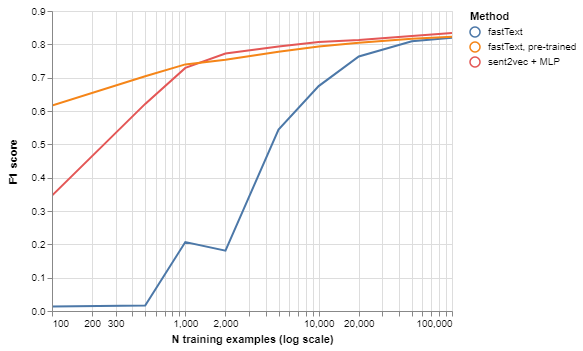

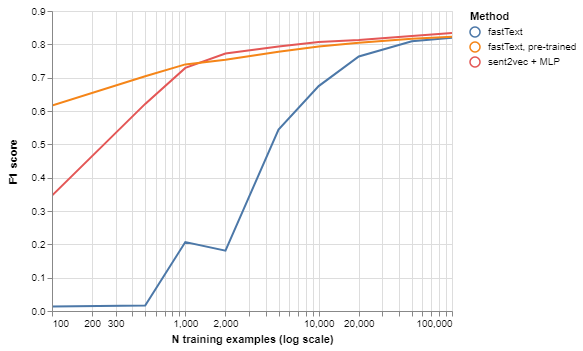

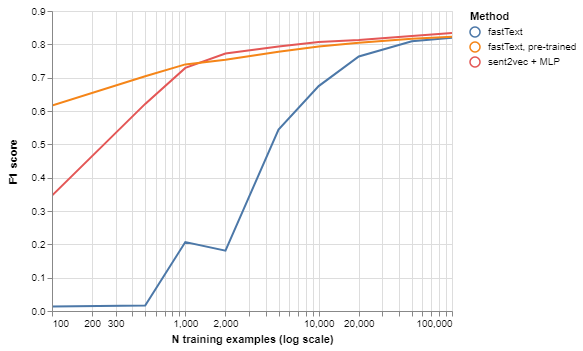

In [142]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(scores).mark_line(clip=True).encode(x=alt.X('N training examples', \
                                                      axis=alt.Axis(title='N training examples (log scale)'), \
                                                      scale=alt.Scale(type='log')), y='F1 score', color='Method')

## Comparision: Dummy classifier (predicting most frequent class)

In [43]:
from sklearn.dummy import DummyClassifier

evaluate_on_k_folds(classifier = DummyClassifier(strategy='most_frequent'), \
                   number_of_training_sentences = n, \
                   number_of_train_and_test_runs = 1)

number_of_training_sentences: 100, (sampled_sentences, including test sentences: 20100)
len y_train 100 y_test 20000
[0.35375]
Median score: 0.35375


0.35375